# Hypothesis 3: Cross-Cultural Moderation
## Effects Stronger in China vs US

**Hypothesis**: The predictive effect of TENS_Life_mean on UTAUT_AI_mean will be stronger for Chinese participants than for U.S. participants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from data_utils import load_and_prepare_data
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
try:
    combined_data = pd.read_csv('data/processed/combined_data.csv')
except FileNotFoundError:
    combined_data = load_and_prepare_data()
    combined_data.to_csv('data/processed/combined_data.csv', index=False)

In [3]:
h3_data = combined_data[['TENS_Life_mean', 'UTAUT_AI_mean', 'country_code', 
                          'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']].dropna()

if h3_data['gender'].dtype == 'object':
    h3_data['gender'] = pd.Categorical(h3_data['gender']).codes

h3_data['TENS_Life_centered'] = h3_data['TENS_Life_mean'] - h3_data['TENS_Life_mean'].mean()
h3_data['TENS_x_Country'] = h3_data['TENS_Life_centered'] * h3_data['country_code']

In [4]:
X_h3 = h3_data[['TENS_Life_centered', 'country_code', 'TENS_x_Country', 
                'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']]
X_h3 = sm.add_constant(X_h3)
y_h3 = h3_data['UTAUT_AI_mean']

model_h3 = sm.OLS(y_h3, X_h3).fit()
print("H3 - Cross-Cultural Moderation:")
print(model_h3.summary())

interaction_coef = model_h3.params['TENS_x_Country']
interaction_p = model_h3.pvalues['TENS_x_Country']
print(f"\nInteraction: β = {interaction_coef:.3f}, p = {interaction_p:.4f}")
print(f"{'✓ H3 SUPPORTED' if interaction_p < 0.05 and interaction_coef > 0 else '✗ H3 NOT SUPPORTED'}")

H3 - Cross-Cultural Moderation:
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     130.5
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          2.02e-159
Time:                        23:01:53   Log-Likelihood:                -1137.5
No. Observations:                2085   AIC:                             2291.
Df Residuals:                    2077   BIC:                             2336.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
cons

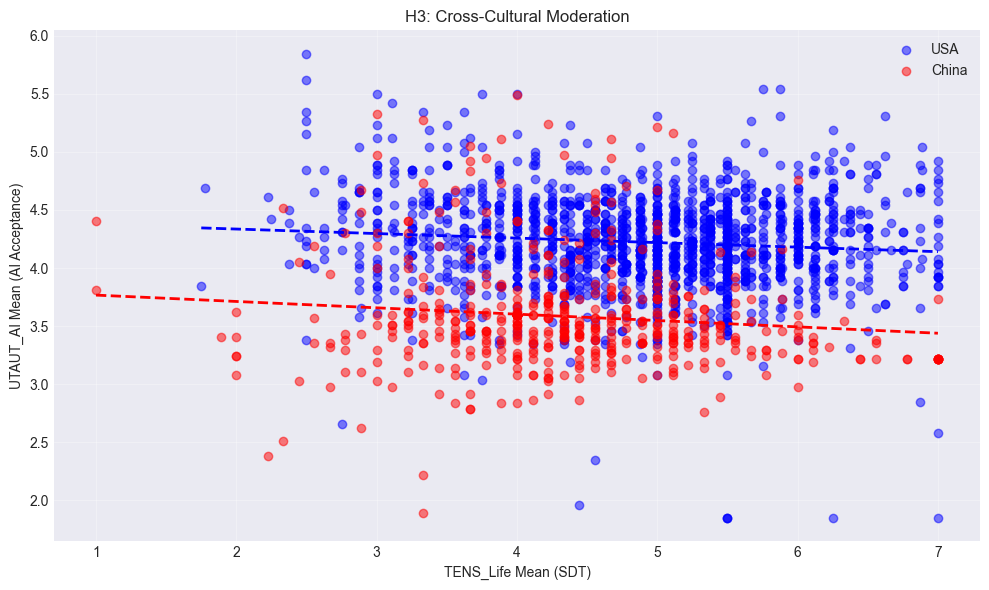

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for country_name, country_code, color in [('USA', 0, 'blue'), ('China', 1, 'red')]:
    country_data = h3_data[h3_data['country_code'] == country_code]
    if len(country_data) > 10:
        z = np.polyfit(country_data['TENS_Life_mean'], country_data['UTAUT_AI_mean'], 1)
        p = np.poly1d(z)
        ax.scatter(country_data['TENS_Life_mean'], country_data['UTAUT_AI_mean'], 
                   alpha=0.5, label=country_name, color=color)
        sorted_x = country_data['TENS_Life_mean'].sort_values()
        ax.plot(sorted_x, p(sorted_x), color=color, linestyle='--', linewidth=2)

ax.set_xlabel('TENS_Life Mean (SDT)')
ax.set_ylabel('UTAUT_AI Mean (AI Acceptance)')
ax.set_title('H3: Cross-Cultural Moderation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()